# Siamese CNN & vae

*Created by Holger Buech, Q1/2019*

**Description**   

Reimplemenation of an approach to Continuous Authentication described by [1]. It leverages a Siamese CNN to generate Deep Features, which are then used as input for an OCSVM authentication classifier.  

**Purpose**

- Verify results of [1]
- Test the approach with upfront global subject wise normalization (NAIVE_APPROACH)
- Change the normalization setting to be more realistic: Training data is normalized upfront again, but the Testing data is normalized using a single scaler fitted on training data only. (VALID_APPROACH)
- Identify parameters performing better in a valid setup than the parameters proposed by [1]. (ALTERNATIVE_APPROACH) 

**Data Sources**   

- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

**References**   

- [1] Centeno, M. P. et al. (2018): Mobile Based Continuous Authentication Using Deep Features. Proceedings of the 2^nd International Workshop on Embedded and Mobile Deep Learning (EMDL), 2018, 19-24.

**Table of Contents**

**1 - [Preparations](#1)**   
1.1 - [Imports](#1.1)   
1.2 - [Configuration](#1.2)   
1.3 - [Experiment Parameters](#1.3)   
1.4 - [Select Approach](#1.4)   

**2 - [Initial Data Prepratation](#2)**   
2.1 - [Load Dataset](#2.1)   
2.2 - [Normalize Features (if global)](#2.2)   
2.3 - [Split Dataset for Valid/Test](#2.3)   
2.4 - [Normalize Features (if not global)](#2.4)   
2.5 - [Check Splits](#2.5)   
2.6 - [Reshape Features](#2.6)     

**3 - [Generate Scenario Pairs](#3)**    
3.1 - [Load cached Data](#3.1)  
3.2 - [Build positive/negative Pairs](#3.2)  
3.3 - [Inspect Pairs](#3.3)  
3.4 - [Cache Pairs](#3.4)  

**4 - [Siamese Network](#4)**  
4.1 - [Load cached Pairs](#4.1)   
4.2 - [Build Model](#4.2)   
4.3 - [Prepare Features](#4.3)   
4.4 - [Search optimal Epoch](#4.4)   
4.5 - [Check Distances](#4.5)   
4.6 - [Rebuild and train to optimal Epoch](#4.6)   
4.7 - [Cache Model](#4.7)   

**5 - [Visualize Deep Features](#5)**   
5.1 - [Load cached Data](#5.1)  
5.2 - [Extract CNN from Siamese Model](#5.2)  
5.3 - [Test Generation of Deep Features](#5.3)  
5.4 - [Visualize in 2D using PCA](#5.4)  

**6 - [OCSVM](#6)**  
6.1 - [Load cached Data](#6.1)  
6.2 - [Load trained Siamese Model](#6.2)  
6.3 - [Search for Parameters](#6.3)  
6.4 - [Inspect Search Results](#6.4) 

**7 - [Testing](#7)**  
7.1 - [Load cached Data](#7.1)  
7.2 - [Evaluate Auth Performance](#7.2)  
7.3 - [Evaluate increasing Training Set Size (Training Delay)](#7.3)  
7.4 - [Evaluate increasing Test Set Sizes (Detection Delay)](#7.4)  

**8 - [Report Results](#8)**  

## 1. Preparations <a id='1'>&nbsp;</a> 

### 1.1 Imports <a id='1.1'>&nbsp;</a> 
**Note:** The custom `DatasetLoader` is a helper class for easier loading and subsetting data from the datasets.

In [1]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp

# Extra
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.decomposition import PCA
import statsmodels.stats.api as sms
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils import plot_model
from keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

# Global utitlity functions are loaded from separate notebook:
%run utils.ipynb

Using TensorFlow backend.


### 1.2 Configuration <a id='1.2'>&nbsp;</a>

In [2]:
# Configure Data Loading & Seed
SEED = 712  # Used for every random function
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
EXCLUDE_COLS = ["sys_time"]
CORES = mp.cpu_count()

# For plots and CSVs
OUTPUT_PATH = Path.cwd() / "output" / "chapter-6-1-4-siamese-cnn"  # Cached data & csvs
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
REPORT_PATH = Path.cwd().parent / "reports" / "figures" # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# Improve performance of Tensorflow (this improved speed _a_lot_ on my machine!!!)
K.tf.set_random_seed(SEED)
conf = K.tf.ConfigProto(
    device_count={"CPU": CORES},
    allow_soft_placement=True,
    intra_op_parallelism_threads=CORES,
    inter_op_parallelism_threads=CORES,
)
K.set_session(K.tf.Session(config=conf))

# Plotting
%matplotlib inline
utils_set_output_style()

# Silence various deprecation warnings...
tf.logging.set_verbosity(tf.logging.ERROR)
np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [3]:
# Workaround to remove ugly spacing between tqdm progress bars:
HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty{padding: 0;border: 0;} div.output_subarea{padding:0;}</style>")

### 1.3 Experiment Parameters <a id='1.3'>&nbsp;</a> 
Selection of parameters set that had been tested in this notebook. Select one of them to reproduce results.

In [4]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    step_width: int  # After resampling

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
    # Data / Splitting
    frequency=25,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "mag_x",
        "mag_y",
        "mag_z",
    ],
    max_subjects=90,
    exclude_subjects=[
        "733162",  # No 24 sessions
        "526319",  # ^
        "796581",  # ^
        "539502",  # Least amount of sensor values
        "219303",  # ^
        "737973",  # ^
        "986737",  # ^
        "256487",  # Most amount of sensor values
        "389015",  # ^
        "856401",  # ^
    ],
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=25,  # 1 sec
    step_width=25,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[2, 4, 6],
    feature_cols=["acc_x", "acc_y", "acc_z"], 
    frequency=25,
    window_size=25*5,
    step_width=25*5,
    scaler="robust",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.001,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.165,
    ocsvm_gamma=8.296,
)

### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

In [5]:
P = NAIVE_MINMAX_2D

**Overview of current Experiment Parameters:**

In [6]:
utils_ppp(P)

,Value
batch_size,200
epochs_best,35
epochs_max,40
exclude_subjects,"[733162, 526319, 796581, 539502, 219303, 73797..."
feature_cols,"[acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z, mag..."
filters,"[32, 64, 128, 32]"
frequency,25
margin,0.2
max_pairs_per_session,60
max_subjects,90


## 2. Initial Data Preparation <a id='2'>&nbsp;</a> 

### 2.1 Load Dataset <a id='2.1'>&nbsp;</a> 

In [7]:
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=P.table_name,
    max_subjects=P.max_subjects,
    task_types=P.task_types,
    exclude_subjects=P.exclude_subjects,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,all,2788.96,28119587,12,90,2160
1,index,0.08,2160,4,90,2160


### 2.2 Normalize Features (if global) <a id='2.2'>&nbsp;</a> 
Used here for naive approach (before splitting into test and training sets). Otherwise it's used during generate_pairs() and respects train vs. test borders.

Normalize all data before splitting into train and test sets...
Before Scaling:


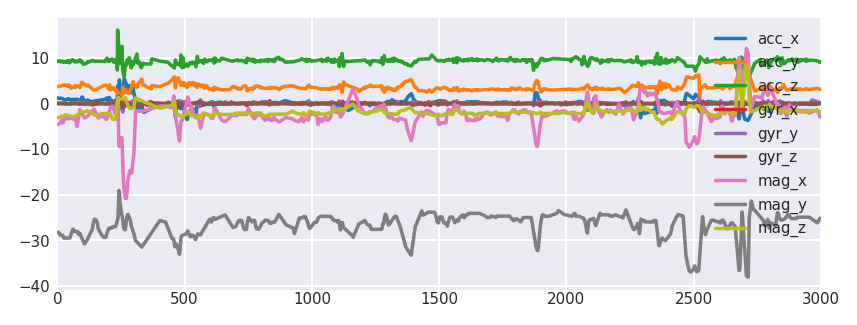

After Scaling:


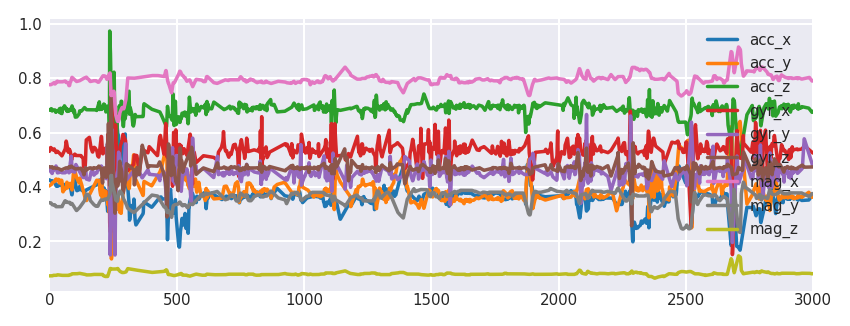

In [8]:
if P.scaler_global:
    print("Normalize all data before splitting into train and test sets...")
    hmog.all, scalers = utils_custom_scale(
        hmog.all,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,
    )
else:
    print("Skipped, normalize after splitting.")

### 2.3 Split Dataset for Valid/Test <a id='2.3'>&nbsp;</a> 
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

In [9]:
hmog.split_train_valid_train_test(
    n_valid_train=P.n_valid_train_subjects,
    n_valid_test=P.n_valid_test_subjects,
    n_test_train=P.n_test_train_subjects,
    n_test_test=P.n_test_test_subjects,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,index,0.08,2160,4,90,2160
1,valid_train,1252.56,12628905,12,40,960
2,valid_test,292.21,2946177,12,10,240
3,test_train,314.94,3175398,12,10,240
4,test_test,929.25,9369107,12,30,720


### 2.4 Normalize features (if not global) <a id='2.4'>&nbsp;</a> 

In [10]:
if not P.scaler_global:
    print("Scaling Data for Siamese Network only...")
    print("Training Data:")
    hmog.valid_train, _ = utils_custom_scale(
        hmog.valid_train,
        scale_cols=P.feature_cols,
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
    print("Validation Data:")
    hmog.valid_test, _ = utils_custom_scale(
        hmog.valid_test,
        scale_cols=P.feature_cols,        
        feature_cols=P.feature_cols,
        scaler_name=P.scaler,
        scope=P.scaler_scope,
        plot=True,        
    )
else:
    print("Skipped, already normalized.")    

Skipped, already normalized.


### 2.5 Check Splits <a id='2.5'>&nbsp;</a> 

### 2.6 Reshape Features  <a id='2.6'>&nbsp;</a> 

**Reshape & cache Set for Training Siamese Network:**

**Reshape & cache Set for Validating Siamese Network:** (also used to optimize OCSVM)

**Reshape & cache Set for Training/Validation OCSVM:**

**Reshape & cache Set for Training/Testing OCSVM:**

## 3. Generate Scenario Pairs <a id='3'>&nbsp;</a> 

### 3.1 Load cached Data <a id='3.1'>&nbsp;</a> 

In [11]:
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")

### 3.2 Build positive/negative Pairs  <a id='3.2'>&nbsp;</a> 

### 3.3 Inspect Pairs <a id='3.3'>&nbsp;</a> 

### 3.4 Cache Pairs <a id='3.4'>&nbsp;</a> 

## 4. Siamese Network <a id='4'>&nbsp;</a> 

### 4.1 Load cached Pairs <a id='4.1'>&nbsp;</a> 

In [12]:
df_siamese_train_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train_pairs.msg")
df_siamese_valid_pairs = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid_pairs.msg")

### 4.2 Build Model <a id='4.2'>&nbsp;</a> 

#### Distance Function

Sanity check contrastive loss function:

#### Siamese Model with 2D Filters, as derived from Centeno et al. (2018)

In [13]:
def build_model_2d(input_shape, filters):
    """
        Siamese CNN architecture with 3D input and 2D filters
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
    x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
    x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
    x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
    x = Flatten(name="flat")(x)
    
    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with 1D Filters, similar than Centeno et al. (2018)

In [14]:
def build_model_1d(input_shape, filters):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
    x = MaxPooling1D(pool_size=2, name="mp1")(x)
    x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
    x = MaxPooling1D(pool_size=2, name="mp2")(x)
    x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
    x = MaxPooling1D(pool_size=2, name="mp3")(x)
    x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
    x = MaxPooling1D(pool_size=2, name="mp5")(x)
    x = Flatten(name="flat")(x)

    # Generate the encodings (feature vectors) for the two images
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the absolute difference between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with FCN architecture

In [15]:
def build_model_fcn(input_shape, filters):
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(
        filters=filters[0],
        kernel_size=8,
        strides=1,
        activation=None,
        padding="same",
        name="conv1",
    )(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop1")(x)
    x = Conv1D(
        filters=filters[1],
        kernel_size=5,
        strides=1,
        activation=None,
        padding="same",
        name="conv2",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop2")(x)
    x = Conv1D(
        filters=filters[2],
        kernel_size=3,
        strides=1,
        activation=None,
        padding="same",
        name="conv3",
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!

    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

In [16]:
def get_model(name, window_size, feature_cols, filters):
    print(f"Using Model variant {name}...")
    if name == "1d":
        model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
    elif name == "2d":
        model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
    elif name == "fcn":
        model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

    return model, basemodel

**Inspect model architecture:**

### 4.3 Prepare Features <a id='4.3'>&nbsp;</a> 

In [17]:
def prep_X_y_pair(df):
    
    X_left = np.stack(list(df["left_X"].values))
    X_right = np.stack(list(df["right_X"].values))
    
    X = [X_left, X_right]
    y = df["label"].values
    
    return X, y

In [18]:
X_train, y_train = prep_X_y_pair(df_siamese_train_pairs)
X_valid, y_valid = prep_X_y_pair(df_siamese_valid_pairs)

# 2D Filter Model needs flat 4th dimension
if P.model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
)

Training samples:   23202, shape: (23202, 125, 3, 1), class balance: (array([0, 1]), array([11601, 11601]))
Validation samples: 5584, shape: (5584, 125, 3, 1), class balance: (array([0, 1]), array([2792, 2792]))


### 4.4 Search optimal Epoch <a id='4.4'>&nbsp;</a> 

In [19]:
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """

    def __init__(self, payload, epoch_evaluate_freq=1, save_plots=False):

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq

        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):
        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_epoch_end(self, epoch, logs={}):
        print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
        if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch)
        else:
            print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")

    def evaluate(self, X, y, logs, desc, epoch):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)

        print(
            f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
            + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
            + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
            + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
        )

        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        plt = utils_plot_distance_hist(
            dist_positive, dist_negative, thres * -1, desc=desc, margin=P.margin
        )

        if self.save_plots:
            utils_save_plot(
                plt,
                REPORT_PATH
                / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
            )

        plt.show()

In [20]:
def get_optimizer(name, lr=None, decay=None):
    if name == "sgd":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(lr=lr, decay=decay)
    elif name == "adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(lr=lr, decay=decay)
    elif name == "rmsprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(lr=lr)
    else:
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer

### 4.5 Check Distances <a id='4.5'>&nbsp;</a> 

### 4.6 Rebuild and train to optimal Epoch  <a id='4.6'>&nbsp;</a> 
Now, that we know the learning curve, we can rebuild the model and train it until the best Epoch.

Also, we will include the validation data to have more training data. 

**Note:** This also means, that the training metrics are not valid anymore, because we don't have any validation data left to test against...

### 4.7 Cache model <a id='4.7'>&nbsp;</a> 

## 5. Visualize Deep Features <a id='5'>&nbsp;</a> 

### 5.1 Load cached Data <a id='5.1'>&nbsp;</a> 

In [21]:
df_siamese_valid = pd.read_msgpack(OUTPUT_PATH / "df_siamese_valid.msg")
df_siamese_train = pd.read_msgpack(OUTPUT_PATH / "df_siamese_train.msg")

df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")

### 5.2 Extract CNN from Siamese Model <a id='5.2'>&nbsp;</a> 
I do this by redirecting inputs and outputs.

However, the network still needs a pair as input (I wasn't able to change this). This slows down a little bit the prediction (as the input is predicted twice), but doesn't change the results.

In [22]:
def load_deep_feature_model(model_path):
    # Copy of function from above. It's just more convenient for partially 
    # executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )
    
    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )
    
    return deep_feature_model

In [24]:
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")
deep_feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
left_inputs (InputLayer)     (None, 25, 9, 1)          0         
_________________________________________________________________
basemodel (Model)            (None, 64)                163616    
Total params: 163,616
Trainable params: 163,616
Non-trainable params: 0
_________________________________________________________________


### 5.3 Test Generation of Deep Features <a id='5.3'>&nbsp;</a> 

In [25]:
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y

In [26]:
def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

#### Select subset (for plotting) and transform features

#### Predict Deep Features

### 5.4 Visualize in 2D using PCA <a id='5.4'>&nbsp;</a> 

## 6. OCSVM <a id='6'>&nbsp;</a> 

### 6.1 Load cached Data <a id='6.1'>&nbsp;</a> 

In [27]:
df_ocsvm_train_valid = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_valid.msg")
df_ocsvm_train_valid.head()

,X,subject,session,task_type
0,"((0.28405073352246657, 0.6230773239920935, 0.1...",186676,186676_session_1,4
1,"((0.5959411489665651, 0.8031653165613303, 0.50...",186676,186676_session_1,4
2,"((0.6756268929946608, 0.8980725662448292, 0.36...",186676,186676_session_1,4
3,"((0.6485716066464491, 0.8142130041255482, 0.51...",186676,186676_session_1,4
4,"((0.6947038513953862, 0.7864652725645278, 0.59...",186676,186676_session_1,4


### 6.2 Load trained Siamese Model <a id='6.2'>&nbsp;</a> 

**Helper methods to load model:**

In [28]:
def load_deep_feature_model(model_path):
    warnings.filterwarnings("ignore")  # Silence depr. warnings

    # Copy of function from above. It's just more convenient for partially executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = P.margin
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )

    # Load Trained Siamese Network
    model = load_model(
        str(model_path.resolve()),
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )

    return deep_feature_model

**Sanity Check:**

### 6.3 Search for Parameters <a id='6.3'>&nbsp;</a> 

In [29]:
df_ocsvm_train_valid.head()

,X,subject,session,task_type
0,"((0.28405073352246657, 0.6230773239920935, 0.1...",186676,186676_session_1,4
1,"((0.5959411489665651, 0.8031653165613303, 0.50...",186676,186676_session_1,4
2,"((0.6756268929946608, 0.8980725662448292, 0.36...",186676,186676_session_1,4
3,"((0.6485716066464491, 0.8142130041255482, 0.51...",186676,186676_session_1,4
4,"((0.6947038513953862, 0.7864652725645278, 0.59...",186676,186676_session_1,4


### 6.4 Inspect Search Results <a id='6.4'>&nbsp;</a> 
**Raw Results & Stats:**

In [30]:
def trans_for_pyod (y) : 
    for i in range(len(y)): 
        if y[i] == -1: 
            y[i]=1
        elif y[i] == 1:
            y[i] = 0 
    return y 

In [39]:
OUTPUT_PATH

PosixPath('/gpfs/fs0/scratch/u/uhengart/ezzeldi/vae_hmog/ContinAuth/notebooks/output/chapter-6-1-4-siamese-cnn')

In [54]:
# best in naive 
encoder_architectures = [
    [16,1],
]
x="NAIVE-MINMAX-2D"
for enc in encoder_architectures[::-1]: 
    if os.path.isfile(OUTPUT_PATH / f"{x+str(enc)}__VAE_ez_yes_params_in_construct__random_search_results_again.csv"): 
        print(enc)
        df_results = pd.read_csv(OUTPUT_PATH / f"{x+str(enc)}__VAE_ez_yes_params_in_construct__random_search_results_again.csv")
        display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
            "owner",
            "rank_test_eer",
            "mean_fit_time",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
                'param_optimizer', 'param_dropout_rate', 'param_contamination', 'param_capacity', 'param_batch_size',
            ]
        ].sort_values("mean_test_eer").head(3) )
        
# VAE(enc,dec,output_activation=activations.softmax,optimizer='sgd',loss=losses.mse,l2_regularizer=.5,hidden_activation=activations.tanh,gamma=1.5,dropout_rate=.25,epochs=400,contamination=.1,capacity=1,batch_size=32)

[16, 1]


,owner,rank_test_eer,mean_fit_time,mean_test_eer,std_test_eer,mean_test_accuracy,std_test_accuracy,param_optimizer,param_dropout_rate,param_contamination,param_capacity,param_batch_size
7,879155,1.0,5.138291,0.088586,0.137422,0.930556,0.137493,sgd,0.25,0.100,1,32
23,710707,1.0,5.178809,0.107592,0.086744,0.930556,0.078567,sgd,0.25,0.100,1,32
37,698266,1.0,5.821271,0.111111,0.000000,0.937500,0.000000,sgd,0.25,0.133,1,32


In [52]:
df_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_optimizer', 'param_dropout_rate', 'param_contamination', 'param_capacity', 'param_batch_size', '879155_test_eer', '785873_test_eer', '201848_test_eer', '368258_test_eer', '710707_test_eer', '186676_test_eer', '827212_test_eer', '815316_test_eer', '698266_test_eer', 'mean_test_eer', 'std_test_eer', 'rank_test_eer', '879155_test_accuracy', '785873_test_accuracy', '201848_test_accuracy', '368258_test_accuracy', '710707_test_accuracy', '186676_test_accuracy', '827212_test_accuracy', '815316_test_accuracy', '698266_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'owner', 'run', '264325_test_eer', '264325_test_accuracy'], dtype='object')

In [53]:
# best in valid 
encoder_architectures = [
    [32,16,1],
]
x="VALID-FCN-ROBUST-FINAL"
for enc in encoder_architectures[::-1]: 
    if os.path.isfile(OUTPUT_PATH / f"{x+str(enc)}__VAE_ez__random_search_results_again.csv"): 
        print(enc)
        df_results = pd.read_csv(OUTPUT_PATH / f"{x+str(enc)}__VAE_ez__random_search_results_again.csv")
        display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
                "owner",
                "mean_test_eer",
                "mean_test_accuracy",
                'param_optimizer', 'param_dropout_rate', 'param_contamination', 'param_capacity', 'param_batch_size'
            ]
        ].sort_values("mean_test_eer").head(1) )

[32, 16, 1]


,owner,mean_test_eer,mean_test_accuracy,param_optimizer,param_dropout_rate,param_contamination,param_capacity,param_batch_size
114,785873,0.224868,0.805556,sgd,0.25,0.125,0.5,32


In [49]:
df_results.columns 

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_optimizer', 'param_dropout_rate', 'param_contamination', 'param_capacity', 'param_batch_size', '879155_test_eer', '785873_test_eer', '201848_test_eer', '368258_test_eer', '710707_test_eer', '186676_test_eer', '827212_test_eer', '815316_test_eer', '698266_test_eer', 'mean_test_eer', 'std_test_eer', 'rank_test_eer', '879155_test_accuracy', '785873_test_accuracy', '201848_test_accuracy', '368258_test_accuracy', '710707_test_accuracy', '186676_test_accuracy', '827212_test_accuracy', '815316_test_accuracy', '698266_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'owner', 'run', '264325_test_eer', '264325_test_accuracy'], dtype='object')

In [34]:
from pyod.models.vae import VAE
from keras import losses
from keras import activations

param_dist = {
                #"l2_regularizer" :  np.linspace(1, 0,5) ,
                "contamination" :   [0.15, 0.133, 0.125, .1 ] ,
                "dropout_rate" :  [.25] ,
                "optimizer" : ['sgd'], 
    
                "batch_size" :  [32],#,16,64],
                #"epochs" : np.linspace(600, 100,3),
                #"gamma" : np.linspace(2, 0,5) , 
                "capacity" : [1] , 
                #"loss": [losses.mse, losses.msle, losses.poisson, losses.mape, losses.mae, losses.kld] , 
                #"output_activation": [ activations.relu, activations.sigmoid, activations.softmax, activations.softplus,
                #                      activations.softsign, activations.tanh, activations.selu, activations.elu, activations.exponential],
                #"hidden_activation": [ activations.relu, activations.sigmoid, activations.softmax, activations.softplus,
                #                      activations.softsign, activations.tanh, activations.selu, activations.elu, activations.exponential]

                 }


# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

encoder_architectures = [
  #  [32,24,16,8,4,2,1],
    
    [32,2],
    [32,1],
    [16,1],
  #  [64,1],
##    [32,16,8,4,2],
##    [32,16,8,4],
 #   [32,16,8,2],
    [32,16,1],
    [32,16,8,1],
    [32,16,8,4,1],
    [32,16,2,1],
    [32,16,8,4,2,1],
]
#all_df_reports=[] 
for enc in encoder_architectures[::-1]: 
    df_results = None  # Will be filled with randomsearch scores
    for run in tqdm(range(1)):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_valid,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                seed=SEED + run,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_valid["subject"].nunique(),
            leave=False,
        ):

            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values
            y=trans_for_pyod(y)

            train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            dec=enc[::-1]

            print(      enc,dec)
            model = VAE(enc,dec,
                           output_activation=activations.softmax,optimizer='adam',loss=losses.mse,l2_regularizer=.5,
                           hidden_activation=activations.tanh,gamma=1.5,dropout_rate=.25,epochs=400,
                           contamination=.5,capacity=1,batch_size=32) 

            warnings.filterwarnings("ignore")
            random_search = RandomizedSearchCV(
                model,
                param_distributions=param_dist,
                cv=train_valid_cv,
                n_iter=80,
                n_jobs=CORES,
                refit=False,
                scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
                verbose=0,
                return_train_score=False,
                iid=False,
                error_score=np.nan,
                random_state=SEED,
            )

            random_search.fit(X, y)

            df_report = utils_cv_report(random_search, owner, impostors)
            df_report["run"] = run
            df_results = pd.concat([df_results, df_report], sort=False)
        #all_df_reports.append([enc,df_results])
        df_results.to_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE_ez_yes_params_in_construct__random_search_results_again.csv", index=False)

[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]
[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]
[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]
[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]
[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]
[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]
[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]
[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]
[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]
[32, 16, 8, 4, 2, 1] [1, 2, 4, 8, 16, 32]



[32, 16, 2, 1] [1, 2, 16, 32]
[32, 16, 2, 1] [1, 2, 16, 32]
[32, 16, 2, 1] [1, 2, 16, 32]
[32, 16, 2, 1] [1, 2, 16, 32]
[32, 16, 2, 1] [1, 2, 16, 32]
[32, 16, 2, 1] [1, 2, 16, 32]
[32, 16, 2, 1] [1, 2, 16, 32]
[32, 16, 2, 1] [1, 2, 16, 32]
[32, 16, 2, 1] [1, 2, 16, 32]
[32, 16, 2, 1] [1, 2, 16, 32]



[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]
[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]
[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]
[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]
[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]
[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]
[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]
[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]
[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]
[32, 16, 8, 4, 1] [1, 4, 8, 16, 32]



[32, 16, 8, 1] [1, 8, 16, 32]
[32, 16, 8, 1] [1, 8, 16, 32]
[32, 16, 8, 1] [1, 8, 16, 32]
[32, 16, 8, 1] [1, 8, 16, 32]
[32, 16, 8, 1] [1, 8, 16, 32]
[32, 16, 8, 1] [1, 8, 16, 32]
[32, 16, 8, 1] [1, 8, 16, 32]
[32, 16, 8, 1] [1, 8, 16, 32]
[32, 16, 8, 1] [1, 8, 16, 32]
[32, 16, 8, 1] [1, 8, 16, 32]



[32, 16, 1] [1, 16, 32]
[32, 16, 1] [1, 16, 32]
[32, 16, 1] [1, 16, 32]
[32, 16, 1] [1, 16, 32]
[32, 16, 1] [1, 16, 32]
[32, 16, 1] [1, 16, 32]
[32, 16, 1] [1, 16, 32]
[32, 16, 1] [1, 16, 32]
[32, 16, 1] [1, 16, 32]
[32, 16, 1] [1, 16, 32]



[16, 1] [1, 16]
[16, 1] [1, 16]
[16, 1] [1, 16]
[16, 1] [1, 16]
[16, 1] [1, 16]
[16, 1] [1, 16]
[16, 1] [1, 16]
[16, 1] [1, 16]
[16, 1] [1, 16]
[16, 1] [1, 16]



[32, 1] [1, 32]
[32, 1] [1, 32]
[32, 1] [1, 32]
[32, 1] [1, 32]
[32, 1] [1, 32]
[32, 1] [1, 32]
[32, 1] [1, 32]
[32, 1] [1, 32]
[32, 1] [1, 32]
[32, 1] [1, 32]



[32, 2] [2, 32]
[32, 2] [2, 32]
[32, 2] [2, 32]
[32, 2] [2, 32]
[32, 2] [2, 32]
[32, 2] [2, 32]
[32, 2] [2, 32]
[32, 2] [2, 32]
[32, 2] [2, 32]
[32, 2] [2, 32]



In [ ]:

print("Best results for each owner: transofrm Y to 0/1 instd -1/1 & contam is .5 32,2")


display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

In [ ]:
#36 16 2
#df_results = pd.read_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE__random_search_results.csv")
print("Best results for each owner: transofrm Y to 0/1 instd -1/1 & contam is .5 32,2")
print('''                          output_activation=activations.softmax,optimizer='adam',loss=losses.mse,l2_regularizer=.5,
                           hidden_activation=activations.tanh,gamma=1.5,dropout_rate=.25,epochs=400,
                           contamination=.5,capacity=1,batch_size=32) ''')

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

In [ ]:
all_df_reports[5][1].head()

In [ ]:
print("Best results for each owner: transofrm Y to 0/1 instd -1/1 ")
print('''     new param search ''')
for enc in encoder_architectures[::-1]: 
    df_results = pd.read_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE_ez__random_search_results_again.csv")
    print("Best results for each owner:")

    display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
                "owner",
                "rank_test_eer",
                "mean_test_eer",
                "std_test_eer",
                "mean_test_accuracy",
                "std_test_accuracy",
            ]
        ].sort_values("mean_test_eer").head(10)
    )

    print("\n\n\nMost relevant statistics:")
    display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
                "mean_fit_time",
                "mean_test_accuracy",
                "std_test_accuracy",
                "mean_test_eer",
                "std_test_eer",
            ]
        ].describe()
    )

In [ ]:
#df_results = pd.read_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE__random_search_results.csv")
print("Best results for each owner: transofrm Y to 0/1 instd -1/1 & contam is .5 32,2")
print('''                          output_activation=activations.softmax,optimizer='adam',loss=losses.mse,l2_regularizer=.5,
                           hidden_activation=activations.tanh,gamma=1.5,dropout_rate=.25,epochs=400,
                           contamination=.5,capacity=1,batch_size=32) ''')

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

In [ ]:
#df_results = pd.read_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE__random_search_results.csv")
print("Best results for each owner: transofrm Y to 0/1 instd -1/1 contam is .25")
'''                          output_activation=activations.softmax,optimizer='adam',loss=losses.mse,l2_regularizer=.5,
                           hidden_activation=activations.tanh,gamma=1.5,dropout_rate=.25,epochs=400,
                           contamination=.5,capacity=1,batch_size=32) '''
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

In [ ]:
#df_results = pd.read_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE__random_search_results.csv")
print("Best results for each owner: WHEN EER func does ypred*-1")

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

In [ ]:
#df_results = pd.read_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE__random_search_results.csv")
print("Best results for each owner: WHEN 1-PREDICT")

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

# try xgbod 
# try OCSVM (best is .13) and LOF (best was .15) from sklearn vs pyod :/ 
https://github.com/yzhao062/Pyod/issues/4
he says they r the same but instead of outliers having lower scores they have higher scores 
# try all pyod models 

In [ ]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP
from pyod.models.cof import COF
from pyod.models.sod import SOD
from pyod.models.xgbod import XGBOD

param_dist = {"contamination" :   np.linspace(.5, 0,6)}

# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with randomsearch scores
'''
modelss = [
    ABOD(), 
    CBLOF(), 
    FeatureBagging(), 
    HBOS(), 
    IForest(), 
    KNN(), 
    LOF(), 
    LOCI(), 
    MCD(), 
    OCSVM(), 
    PCA(), 
    SOS(), 
    LSCP(), 
    COF(), 
    SOD(), 
]
for mooo in modelss: 
'''
for run in tqdm(range(1)):
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_valid,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED + run,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_valid["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = XGBOD()  #mooo

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=80,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)

        df_report = utils_cv_report(random_search, owner, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_random_search_results.csv", index=False)

In [ ]:
for enc in encoder_architectures[::-1]: 
    df_results = pd.read_csv(OUTPUT_PATH / f"{P.name+str(enc)}__VAE__random_search_results.csv")
    print("Best results for each owner:")

    display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
                "owner",
                "rank_test_eer",
                "mean_test_eer",
                "std_test_eer",
                "mean_test_accuracy",
                "std_test_accuracy",
            ]
        ].sort_values("mean_test_eer").head(10)
    )

    print("\n\n\nMost relevant statistics:")
    display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
                "mean_fit_time",
                "mean_test_accuracy",
                "std_test_accuracy",
                "mean_test_eer",
                "std_test_eer",
            ]
        ].describe()
    )

**Plot parameters of top n of 30 results for every Owner:**

In [ ]:
utils_plot_randomsearch_results(df_results, 1)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-parameters.pdf")

## 7. Testing <a id='7'>&nbsp;</a> 

### 7.1 Load cached Data <a id='7.1'>&nbsp;</a> 
During testing, a split with different users than used for hyperparameter optimization is used:

In [57]:
df_ocsvm_train_test = pd.read_msgpack(OUTPUT_PATH / "df_ocsvm_train_test.msg")

### 7.2 Evaluate Authentication Performance <a id='7.2'>&nbsp;</a> 
- Using Testing Split, Scenario Cross Validation, and multiple runs to lower impact of random session/sample selection.

In [79]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            seed=SEED,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):

        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values
        y = trans_for_pyod(y)

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = VAE([16,1],[1,16],output_activation=activations.softmax,optimizer='sgd',loss=losses.mse,l2_regularizer=.5,hidden_activation=activations.tanh,gamma=1.5,dropout_rate=.25,epochs=400,contamination=.1,capacity=1,batch_size=32)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            n_jobs=CORES,
            verbose=1,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_VAE_test_results.csv", index=False)
df_results.head()

[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   24.1s remaining:   10.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   24.4s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.1s remaining:    3.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    9.0s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.8s remaining:    3.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    8.0s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.7s remaining:    2.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    4.9s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parall

[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.1s remaining:    4.5s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   12.7s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   10.8s remaining:    4.8s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   20.6s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   18.0s remaining:    8.1s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   18.0s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:   14.8s remaining:    6.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   19.0s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parall

[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.2s remaining:    2.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    6.0s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.7s remaining:    2.6s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    7.4s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    7.6s remaining:    3.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   12.2s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    8.1s remaining:    3.7s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   11.6s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parall

[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.1s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.4s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.1s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.4s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.4s remaining:    2.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.6s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.3s remaining:    2.4s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.6s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parall

[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.9s remaining:    2.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.3s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.0s remaining:    2.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.0s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    4.9s remaining:    2.2s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.2s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done  20 out of  29 | elapsed:    5.2s remaining:    2.3s
[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:    5.4s finished
[Parallel(n_jobs=80)]: Using backend LokyBackend with 80 concurrent workers.
[Parall

[Parallel(n_jobs=80)]: Done  29 out of  29 | elapsed:   20.3s finished


,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,owner
0,5.073573,0.004457,0.0,1.818989e-12,1.0,0.888889,872895
1,5.617980,0.004216,0.0,1.818989e-12,1.0,0.888889,872895
2,5.710021,0.004874,0.0,1.818989e-12,1.0,0.888889,872895
3,5.566065,0.003936,0.0,1.818989e-12,1.0,0.888889,872895
4,5.659665,0.004375,0.0,1.818989e-12,1.0,0.888889,872895


In [65]:
df_results.head()

,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,owner
0,5.054659,0.006782,1.0,1.818989e-12,0.0,0.111111,872895
1,5.613846,0.005916,1.0,1.818989e-12,0.0,0.111111,872895
2,5.739707,0.007254,1.0,1.818989e-12,0.0,0.111111,872895
3,5.669161,0.006190,1.0,1.818989e-12,0.0,0.111111,872895
4,5.689848,0.006828,1.0,1.818989e-12,0.0,0.111111,872895


**Load Results from "EER & Accuracy" evaluation & prepare for plotting:**

In [59]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_VAE_test_results.csv")
df_plot = df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

In [62]:
df_plot.columns

Index(['fit_time', 'score_time', 'Test EER', 'train_eer', 'Test Accuracy', 'train_accuracy', 'Owner'], dtype='object')

In [66]:
x="NAIVE-MINMAX-2D"
for enc in encoder_architectures[::-1]: 
    if os.path.isfile(OUTPUT_PATH / f"{x+str(enc)}__VAE_ez_yes_params_in_construct__random_search_results_again.csv"): 
        print(enc)
        df_results = pd.read_csv(OUTPUT_PATH / f"{x+str(enc)}__VAE_ez_yes_params_in_construct__random_search_results_again.csv")
        display(
        df_results[df_results["rank_test_eer"] <= 1][
            [
            "owner",
            "rank_test_eer",
            "mean_fit_time",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
            ]
        ].sort_values("mean_test_eer").head(3) )

[16, 1]


,owner,rank_test_eer,mean_fit_time,mean_test_eer,std_test_eer,mean_test_accuracy,std_test_accuracy
7,879155,1.0,5.138291,0.088586,0.137422,0.930556,0.137493
23,710707,1.0,5.178809,0.107592,0.086744,0.930556,0.078567
37,698266,1.0,5.821271,0.111111,0.000000,0.937500,0.000000


In [78]:
x="NAIVE-MINMAX-2D"
for enc in encoder_architectures[::-1]: 
    if os.path.isfile(OUTPUT_PATH / f"{P.name}_VAE_test_results.csv"): 
        df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_VAE_test_results.csv")
        display(
        df_results.sort_values("test_eer", ascending=True).head(10) )

,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,owner
4312,5.197601,0.004065,0.447368,1.818989e-12,0.145833,0.111111,841866
1702,5.127579,0.004181,0.447368,1.818989e-12,0.145833,0.111111,841866
2572,4.595778,0.004694,0.447368,1.818989e-12,0.145833,0.111111,841866
3442,5.965145,0.004776,0.447368,1.818989e-12,0.145833,0.111111,841866
832,5.484068,0.005949,0.447368,1.818989e-12,0.145833,0.111111,841866
2972,5.304060,0.004508,0.461538,1.818989e-12,0.125000,0.111111,342329
1232,4.960689,0.005116,0.461538,1.818989e-12,0.125000,0.111111,342329
362,5.370130,0.004678,0.461538,1.818989e-12,0.125000,0.111111,342329
3842,5.806026,0.006084,0.461538,1.818989e-12,0.125000,0.111111,342329
2102,4.560217,0.005818,0.461538,1.818989e-12,0.125000,0.111111,342329


**Plot Distribution of Accuracy per subject:**

Overall mean: 0.0770


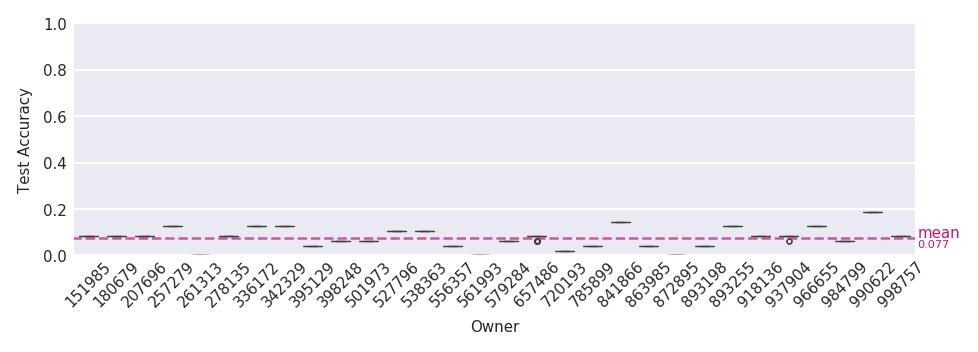

In [63]:
fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-acc.pdf")

**Plot Distribution of EER per subject:**

Overall mean: 0.8604


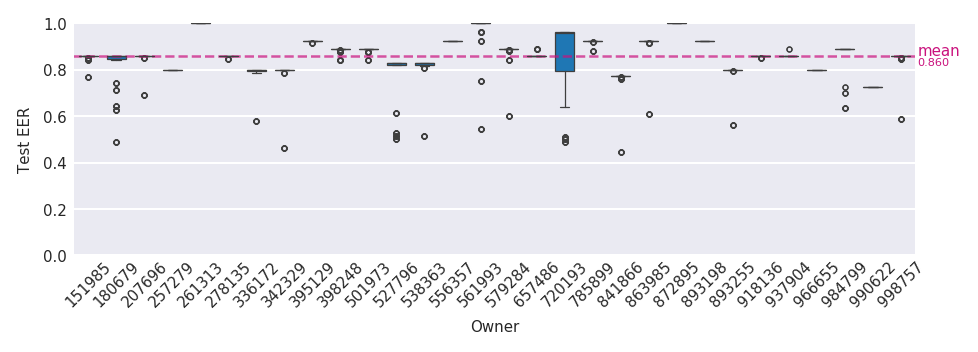

In [64]:
fig = utils_plot_acc_eer_dist(df_plot, "Test EER") # with new archi [32,16,4,1],[1,4,16,32] instead of [32,16,8,4,1],[1,4,8,16,32]
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

In [ ]:
fig = utils_plot_acc_eer_dist(df_plot, "mean_test_eer")
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-eer.pdf")

### 7.3 Evaluate increasing Training Set Size (Training Delay) <a id='7.3'>&nbsp;</a> 

In [ ]:
training_set_sizes = [1, 2, 3, 4, 10, 30, 60, 90, 125, 175, 250, 375]  # In samples

deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(5), desc="Run", leave=False):  # Run whole test 5 times
    for n_train_samples in tqdm(training_set_sizes, desc="Train Size", leave=False):
        for df_cv_scenarios, owner, impostors in tqdm(
            utils_generate_cv_scenarios(
                df_ocsvm_train_test,
                samples_per_subject_train=P.samples_per_subject_train,
                samples_per_subject_test=P.samples_per_subject_test,
                limit_train_samples=n_train_samples,  # samples overall
                seed=SEED + i,
                scaler=P.scaler,
                scaler_global=P.scaler_global,
                scaler_scope=P.scaler_scope,
                deep_model=deep_feature_model,
                model_variant=P.model_variant,
                feature_cols=P.feature_cols,
            ),
            desc="Owner",
            total=df_ocsvm_train_test["subject"].nunique(),
            leave=False,
        ):
            X = np.array(df_cv_scenarios["X"].values.tolist())
            y = df_cv_scenarios["label"].values

            train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

            model = VAE([32,16,8,4,1],[1,4,8,16,32], contamination=.5, optimizer='sgd',                
                gamma=3 , 
                capacity=.5 , 
                loss=losses.kld,
                batch_size=32, 
                dropout_rate=.25,
                epochs=200,
                output_activation=activations.selu, 
                hidden_activation=activations.sigmoid, 
    )

            warnings.filterwarnings("ignore")
            scores = cross_validate(
                model,
                X,
                y,
                cv=train_test_cv,
                scoring={"eer": utils_eer_scorer},
                n_jobs=CORES,
                verbose=0,
                return_train_score=True,
            )
            df_score = pd.DataFrame(scores)
            df_score["owner"] = owner
            df_score["train_samples"] = n_train_samples
            df_score["train_eer"] = df_score[
                "train_eer"
            ].abs()  # Revert scorer's signflip
            df_score["test_eer"] = df_score["test_eer"].abs()
            df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv", index=False)
df_results.head()

**Load Results from "Training set size" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_train_delay_results.csv")
df_plot = (
    df_results[["test_eer", "owner", "train_samples"]]
    .groupby(["owner", "train_samples"], as_index=False)
    .mean()
    .astype({"owner": "category"})
    .rename(
        columns={
            "test_eer": "Test EER",
            "owner": "Owner",
        }
    )
)
df_plot["Training Data in Seconds"] = df_plot["train_samples"] * P.window_size / P.frequency

**Plot EER with increasing number of training samples:**

In [ ]:
utils_plot_training_delay(df_plot)
utils_save_plot(plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-train-size.pdf")

### 7.4 Evaluate increasing Test Set Sizes (Detection Delay)<a id='7.4'>&nbsp;</a> 

In [ ]:
# Load Siamese CNN Model
deep_feature_model = load_deep_feature_model(OUTPUT_PATH / f"{P.name}_model.h5")

df_results = None  # Will be filled with cv scores
for i in tqdm(range(50), desc="Run", leave=False):  # Run whole test 5 times
    for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_ocsvm_train_test,
            samples_per_subject_train=P.samples_per_subject_train,
            samples_per_subject_test=P.samples_per_subject_test,
            limit_test_samples=1,  # Samples overall
            seed=SEED + i,
            scaler=P.scaler,
            scaler_global=P.scaler_global,
            scaler_scope=P.scaler_scope,
            deep_model=deep_feature_model,
            model_variant=P.model_variant,
            feature_cols=P.feature_cols,
        ),
        desc="Owner",
        total=df_ocsvm_train_test["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values

        train_test_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = VAE([32,16,8,4,1],[1,4,8,16,32], contamination=.5, optimizer='sgd',                
                gamma=3 , 
                capacity=.5 , 
                loss=losses.kld,
                batch_size=32, 
                dropout_rate=.25,
                epochs=200,
                output_activation=activations.selu, 
                hidden_activation=activations.sigmoid, 
    )

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_test_cv,
            scoring={"eer": utils_eer_scorer},
            n_jobs=CORES,
            verbose=0,
            return_train_score=True,
        )
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["run"] = i
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results = pd.concat([df_results, df_score], axis=0)

df_results.to_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv", index=False)
df_results.head()

**Load Results from "Detection Delay" evaluation & prepare for plotting:**

In [ ]:
df_results = pd.read_csv(OUTPUT_PATH / f"{P.name}_detect_delay_results.csv")
df_results["owner"] = df_results["owner"].astype(str)
df_plot = df_results.copy()

**Plot Expanding Mean EER and confidence interval:**

In [ ]:
utils_plot_detect_delay(df_plot, factor=P.window_size / P.frequency, xlim=160)
utils_save_plot(
    plt, REPORT_PATH / f"buech2019-siamese-{P.name.lower()}-detection-delay.pdf"
)